In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys

# Make sure notebook can import from src folder
sys.path.append(os.path.abspath("../src"))

# Plotting defaults
%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["figure.dpi"] = 120
sns.set_style("whitegrid")

In [ ]:
from data_pipeline.loaders import load_standardized_options, load_option_volume_wrds

px  = load_standardized_options("spy")
vol = load_option_volume_wrds("spy")

print("px cols:", px.columns.tolist()[:12])
display(px.head())

print("vol cols:", vol.columns.tolist()[:12])
display(vol.head())

<<<<<<< local <modified: >


All raw files present & materialized ✅
⚠️ SPY has many NaNs — verify source file/columns. Proceeding anyway.


>>>>>>> remote <removed>
C:\Users\Admin\deep-hedging-rl\src\data_pipeline\io_utils.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  if pd.to_datetime(df[c], errors="coerce").notna().mean() > 0.9:
C:\Users\Admin\deep-hedging-rl\src\data_pipeline\io_utils.py:74: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  out["date"] = pd.to_datetime(out["date"], errors="coerce")
C:\Users\Admin\deep-hedging-rl\src\data_pipeline\io_utils.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  if pd.to_datetime(df[c], errors="coerce").notna().mean() > 0.9:
C:\Users\Admin\deep-hedging-rl\src\

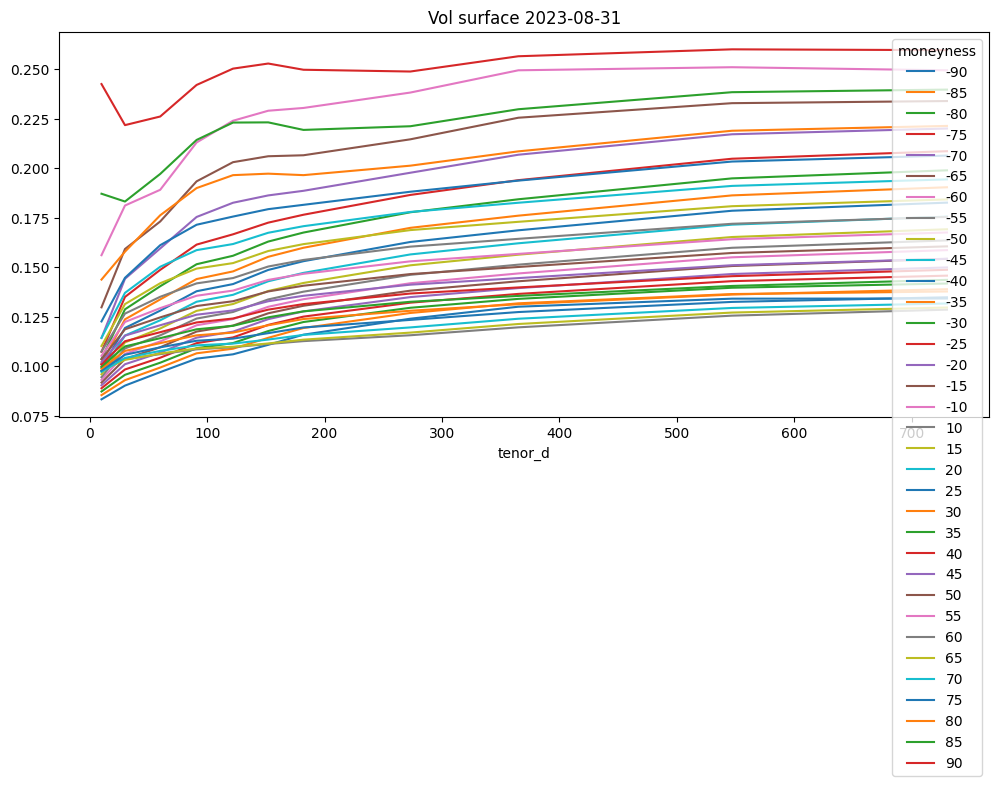

In [ ]:
# 01_data_exploration.ipynb

# --- setup ---
import pandas as pd
import matplotlib.pyplot as plt

from data_pipeline.validate import validate_raw
from data_pipeline.builders import (
    build_market_daily,
    build_options_snapshot,
    build_vol_surface_long,
    build_market_plus_hvol_fwd,
)

# --- 0) check LFS files are materialized ---
validate_raw()   # will error if someone forgot `git lfs pull`

# --- 1) macro/market series ---
mkt = build_market_daily(save=False)
print("Market daily shape:", mkt.shape)
display(mkt.tail())

# --- 2) options snapshot (SPY) ---
opt_spy = build_options_snapshot("spy", save=False)
print("Options snapshot shape:", opt_spy.shape)
display(opt_spy.head())

# --- 3) vol surface (SPY) ---
surf_spy = build_vol_surface_long("spy", save=False)
print("Vol surface shape:", surf_spy.shape)
display(surf_spy.head())

# pivot tenor vs moneyness for the latest date
d0 = surf_spy['date'].max()
surf0 = surf_spy.query("date == @d0").pivot(
    index='tenor_d', columns='moneyness', values='iv'
)
surf0.plot(title=f"Vol surface {d0.date()}", figsize=(12,5))
plt.show()

In [ ]:
opt_spy

In [ ]:
# speed knobs
LAST_N_DAYS = 730  # 2 years; bump up/down as needed

# ensure datetime and filter recent window
opt_spy_fast = opt_spy.copy()
opt_spy_fast["date"] = pd.to_datetime(opt_spy_fast["date"], errors="coerce")
cutoff = opt_spy_fast["date"].max() - pd.Timedelta(days=LAST_N_DAYS)
opt_spy_fast = opt_spy_fast.loc[opt_spy_fast["date"] >= cutoff]

# keep only sensible rows for Greeks/prices
opt_spy_fast = opt_spy_fast[(opt_spy_fast["mid"] > 0) & opt_spy_fast["iv"].notna()]

# aggregate to daily medians by put/call (massive downsample)
agg_cols = ["mid", "iv", "delta", "gamma", "theta", "vega"]
daily = (
    opt_spy_fast
    .groupby(["date", "put_call"], as_index=False)[agg_cols]
    .median()
    .sort_values("date")
)
daily.head()

In [ ]:
for col in ["mid", "iv", "delta", "gamma", "theta", "vega"]:
    plt.figure(figsize=(10, 4))
    plt.title(f"SPY options — daily median {col} (last {LAST_N_DAYS} days)")
    sns.lineplot(data=daily, x="date", y=col, hue="put_call", errorbar=None, lw=1)
    plt.xlabel("date"); plt.ylabel(col)
    plt.tight_layout()
    plt.show()

In [ ]:
# example slice: near-the-money & short tenors
mask = (
    opt_spy["moneyness"].between(0.95, 1.05) &
    (opt_spy["tenor_d"].between(7, 45))
)
opt_slice = opt_spy.loc[mask].copy()
# then repeat the same aggregation/plotting steps on `opt_slice`

In [ ]:
print("mkt shape:", mkt.shape)
display(mkt.tail(3))
print("Columns:", list(mkt.columns))
print("NaNs by column:")
display(mkt.isna().sum())

In [ ]:
mkt = mkt.copy()
if "date" in mkt.columns:
    mkt["date"] = pd.to_datetime(mkt["date"], errors="coerce")
    mkt = mkt.sort_values("date").set_index("date")
else:
    mkt.index = pd.to_datetime(mkt.index, errors="coerce")
    mkt = mkt.sort_index()

print("Index dtype:", mkt.index.dtype)
display(mkt.tail(3))

In [ ]:
# Try common price column names; adjust if your build uses different ones
price_cols_try = ["close", "adj_close", "px_close", "price", "spot"]
spot_col = next((c for c in price_cols_try if c in mkt.columns), None)

if spot_col is None:
    raise ValueError(f"Could not find a spot price column in mkt. Saw: {list(mkt.columns)[:10]}")

mkt["ret"] = mkt[spot_col].pct_change()
mkt["log_ret"] = np.log(mkt[spot_col]).diff()
print("Using spot column:", spot_col)
display(mkt[[spot_col, "ret", "log_ret"]].tail(5))

In [ ]:
# 21d (≈1 month) rolling realized vol, annualized
ROLL = 21
mkt["rv_21"] = mkt["log_ret"].rolling(ROLL).std() * np.sqrt(252)
display(mkt[[spot_col, "rv_21"]].tail(5))

In [ ]:
LAST_N_DAYS = 365 * 2  # last 2 years
mkt_plot = mkt.iloc[-LAST_N_DAYS:].copy()

fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
mkt_plot[spot_col].plot(ax=ax[0], lw=1)
ax[0].set_title(f"{spot_col} (last {LAST_N_DAYS} days)")

mkt_plot["rv_21"].plot(ax=ax[1], lw=1)
ax[1].set_title("Realized Vol (21d, annualized)")
plt.tight_layout()
plt.show()

In [ ]:
# Try to detect a VIX/implied vol column
iv_cols_try = ["vix", "iv_30d", "implied_vol", "hvol_30d"]
iv_col = next((c for c in iv_cols_try if c in mkt.columns), None)

if iv_col is not None:
    comp = mkt[[iv_col, "rv_21"]].dropna().iloc[-LAST_N_DAYS:]
    print(f"Comparing {iv_col} vs realized vol (rv_21)")
    display(comp.tail(3))

    fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
    comp[iv_col].plot(ax=ax[0], lw=1)
    ax[0].set_title(iv_col)
    comp["rv_21"].plot(ax=ax[1], lw=1, color="tab:orange")
    ax[1].set_title("Realized Vol (21d, annualized)")
    plt.tight_layout()
    plt.show()

    corr = comp.corr().round(3)
    print("Correlation matrix:")
    display(corr)
else:
    print("No implied vol/VIX-like column found; skipped IV vs RV comparison.")

In [ ]:
from data_pipeline.qc import coverage, assert_min_coverage

# --- ensure required columns exist ---
required = ["spy", "rate_10y"]

# try to find a plausible spot column and alias it to 'spy' if missing
if "spy" not in mkt.columns:
    spot_candidates = ["close", "adj_close", "px_close", "price", "spot", "spy_close"]
    spot_col = next((c for c in spot_candidates if c in mkt.columns), None)
    if spot_col is not None:
        mkt = mkt.copy()
        mkt["spy"] = mkt[spot_col]
        print(f"Aliased spot column '{spot_col}' -> 'spy'")
    else:
        print("⚠️ Could not find a spot column to alias to 'spy'. Available cols:", list(mkt.columns)[:15])

# gentle notice if 10y rate is missing
if "rate_10y" not in mkt.columns:
    print("⚠️ 'rate_10y' not found in mkt columns. QC will likely fail this requirement.")

# --- run coverage + assertion ---
cov = coverage(mkt)
print("Coverage summary:\n", cov)

# only assert for the columns that actually exist to avoid hard crashes
existing_required = [c for c in required if c in mkt.columns]
if existing_required:
    assert_min_coverage(mkt, existing_required, 0.60)
    print(f"✅ Minimum coverage OK for: {existing_required} (>= 60%)")
else:
    print("⚠️ None of the required columns were present; skipped assert_min_coverage.")

In [ ]:
# --- robust column detection ---
def pick_col(df, candidates):
    return next((c for c in candidates if c in df.columns), None)

spy_col  = pick_col(mkt, ["spy","close_spy","spot","close","adj_close","px_close"])
gspc_col = pick_col(mkt, ["close_gspc","spx","gspc","^GSPC","px_spx","close_spx"])
vix_col  = pick_col(mkt, ["vix","vix_close","iv_30d","implied_vol"])
rate_col = pick_col(mkt, ["rate_10y","ust10y","t10y","yield_10y"])

print("Detected columns:", {"spy": spy_col, "gspc": gspc_col, "vix": vix_col, "rate_10y": rate_col})

# rows where at least one series has data
mkt_any = mkt[mkt.notna().any(axis=1)]

# rows where ALL detected series are present
present_required = [c for c in [spy_col, gspc_col, vix_col, rate_col] if c is not None]
mkt_all = mkt.dropna(subset=present_required) if present_required else mkt.copy()

# start from the first valid SPY point (if we found a spy column)
if spy_col is not None and mkt[spy_col].first_valid_index() is not None:
    mkt_from_spy = mkt.loc[mkt[spy_col].first_valid_index():]
else:
    mkt_from_spy = mkt.copy()

print("Shapes:", {"mkt_any": mkt_any.shape, "mkt_all": mkt_all.shape, "mkt_from_spy": mkt_from_spy.shape})

In [ ]:
# 01_data_exploration.ipynb

# --- setup ---
import pandas as pd
import matplotlib.pyplot as plt

from data_pipeline.validate import validate_raw
from data_pipeline.builders import (
    build_market_daily,
    build_options_snapshot,
    build_vol_surface_long,
    build_market_plus_hvol_fwd,
)

# --- 0) check LFS files are materialized ---
validate_raw()   # will error if someone forgot `git lfs pull`

# --- 1) macro/market series ---
mkt = build_market_daily(save=False)
mkt.tail()

# --- 2) options snapshot (SPY) ---
opt_spy = build_options_snapshot("spy", save=False)
opt_spy.head()

# --- 3) vol surface (SPY) ---
surf_spy = build_vol_surface_long("spy", save=False)
surf_spy.head()

# pivot tenor vs moneyness for a date
d0 = surf_spy['date'].max()
surf0 = surf_spy.query("date == @d0").pivot(index='tenor_d', columns='moneyness', values='iv')
surf0.plot(title=f"Vol surface {d0.date()}", figsize=(12,5))
plt.show()


In [ ]:
display(mkt_all.head())

axes = mkt_all.plot(
    subplots=True,
    figsize=(12, 8),
    title="Market Series",
    lw=1
)

for ax in axes:
    ax.set_xlabel("")
plt.tight_layout()
plt.show()

In [ ]:
print("Vol surface shape:", surf_spy.shape)
print("Columns:", surf_spy.columns.tolist())
display(surf_spy.head())

print("\nNaN counts:")
display(surf_spy.isna().sum())

print("\nUnique tenors (days):", surf_spy['tenor_d'].unique()[:10])
print("Unique moneyness (sample):", surf_spy['moneyness'].unique()[:10])

In [ ]:
# --- Clean SPY option data ---
print("Before cleaning:", len(opt_spy))

opt_spy_clean = opt_spy.copy()

# Drop rows with missing implied vol or Greeks
cols_to_check = ["iv", "delta", "gamma", "vega"]
opt_spy_clean = opt_spy_clean.dropna(subset=cols_to_check)

# Filter out zero or negative strikes/mid prices
opt_spy_clean = opt_spy_clean[
    (opt_spy_clean["strike"] > 0) &
    (opt_spy_clean["mid"] > 0)
]

# Ensure date is parsed
opt_spy_clean["date"] = pd.to_datetime(opt_spy_clean["date"], errors="coerce")

print("After cleaning:", len(opt_spy_clean))
display(opt_spy_clean.head())

In [ ]:
# Quick range check for key columns
for col in ["iv", "delta", "gamma", "vega", "theta", "mid"]:
    if col in opt_spy_clean.columns:
        print(f"{col:>6} range: {opt_spy_clean[col].min():.4f}  to  {opt_spy_clean[col].max():.4f}")

In [ ]:
# Plot IV smiles for a few expiries
sample_expiries = opt_spy_clean["expiry"].dropna().unique()[:3]  # first 3 expiries
for exp in sample_expiries:
    data = opt_spy_clean[opt_spy_clean["expiry"] == exp]
    plt.figure(figsize=(8,4))
    plt.scatter(data["strike"], data["iv"], alpha=0.5)
    plt.title(f"IV smile for expiry {exp}")
    plt.xlabel("Strike")
    plt.ylabel("Implied Volatility")
    plt.show()

In [ ]:
iv_term = opt_spy_clean.groupby("expiry")["iv"].mean().sort_index()
iv_term.plot(marker="o", title="Average IV Term Structure")
plt.ylabel("Implied Volatility")
plt.show()

In [ ]:
merged = pd.merge(
    opt_spy_clean[["date","iv"]].groupby("date").mean(),
    mkt[["rv_21"]],
    left_index=True, right_index=True, how="inner"
)
merged.plot(title="Average Option IV vs Realized Vol (21d)")
plt.show()
print("Correlation:", merged.corr().iloc[0,1].round(3))

In [ ]:
opt_spy_clean.to_parquet("../data/opt_spy_clean.parquet", index=False)
print("Saved cleaned SPY options to parquet.")